# PPM Linear Advection Example

The linear advection equation is:

$$a_t + u a_x = 0$$

written in conservative form, we have:

$$a_t + [u a]_x = 0$$

where $F(a) = ua$ can be recognized as the flux.

A finite-volume update of this is found by integrating our linear advection equation over the volume of a zone, defining an average as:

$$\langle a\rangle_i = \frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i+1/2}} a(x) dx$$

which gives:

$$\langle a\rangle_i^{n+1} = \langle a \rangle_i^n + \frac{\Delta t}{\Delta x} (F_{i-1/2}^{n+1/2}(a) - F_{i+1/2}^{n+1/2}(a))$$

We compute the time-centered flux, $F^{n+1/2}(a)$, but reconstructing $a(x)$ as a parabola and the integrating under that parabola a distance $u \Delta t$ from the interface.

If $a_i(x)$ is a parabolic reconstruction of $a$ in zone $i$, then we can integrate to the left and right edges of zone $i$ to get:

$$\mathcal{I}_+(a_i) = \frac{1}{|u| \Delta t}\int_{x_{i+1/2}- |u| \Delta t}^{x_{i+1/2}} a(x) dx$$

$$\mathcal{I}_-(a_i) = \frac{1}{|u| \Delta t}\int_{x_{i-1/2}}^{x_{i-1/2} + |u|\Delta t} a(x) dx$$

Notice that zone $i$ gives the $+$ state on interface $i+1/2$ and the $-$ state on interface $i-1/2$.  Once this
is done for every zone, we have left and right states on each interface:

$$a_{i+1/2,L}^{n+1/2} = \mathcal{I}_+(a_i)$$

$$a_{i+1/2,R}^{n+1/2} = \mathcal{I}_-(a_{i+1})$$

We then can do upwinding to find the true interface state (this is the Riemann problem for linear advection):

$$a_{i+1/2}^{n+1/2} = \left \{ \begin{array}{cc} a_{i+1/2,L}^{n+1/2} & \mbox{if } u > 0 \\
                                                 a_{i+1/2,R}^{n+1/2} & \mbox{if } u < 0 \end{array} \right .$$

and finally express the flux as:

$$F^{n+1/2}_{i+1/2} = u\, a_{i+1/2}^{n+1/2}$$

## Writing our own advection solver

The `PPMInterpolant` class provides the methods to reconstruct the data and compute the integrals under the parabola.

Below we write out the functions to construct the interface states via PPM interpolation and do the finite-volume update.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ppmpy import FVGrid, PPMInterpolant

We generate the left and right states by reconstructing each cell's data as a parabola and then integrating under the parabola along the distance $u \Delta$ from the interface.  

```{important}
`PPMInterpolant` works with the dimensionless quantity
$\sigma = u \Delta t / \Delta x$--notice that there is no absolute value here.
```

In [3]:
def states(grid, a, u, dt):
    a_ppm = PPMInterpolant(grid, a)
    sigma = u * dt / grid.dx
    
    # Im is the left side of the zone, Ip is the right side of the zone
    Im, Ip = a_ppm.integrate(sigma)

    # convert these to be left and right of an interface
    a_left = grid.scratch_array()
    a_right = grid.scratch_array()

    a_right[:] = Im[:]
    a_left[1:] = Ip[:-1]

    return a_left, a_right

Here's the driver.  The basic evolution loop is:
* fill ghost cells
* predict interface states
* solve Riemann problem (just upwinding for us)
* do the conservative update

In [4]:
def advection(nx, u, C, *, num_periods=1, init_cond=None):

    g = FVGrid(nx, ng=3)

    t_period = (g.xmax - g.xmin) / np.abs(u)
    tmax = num_periods * t_period

    # setup the initial conditions
    a_init = init_cond(g)
    
    # compute the timestep
    dt = C * g.dx / np.abs(u)

    a = g.scratch_array()
    a[:] = a_init[:]
    
    t = 0.0
    while t < tmax:
        if t + dt > tmax:
            dt = tmax - t

        g.ghost_fill(a, bc_left_type="periodic", bc_right_type="periodic")

        # get the interface states
        a_left, a_right = states(g, a, u, dt)

        # solve the Riemann problem
        a_int = np.where(u > 0, a_left, a_right)
        
        # do the update
        a[g.lo:g.hi+1] += -dt * u * (a_int[g.lo+1:g.hi+2] - a_int[g.lo:g.hi+1]) / g.dx
        t += dt

    return g, a

Our initial conditions will be a simple tophat profile

In [5]:
def tophat(g):
    a = g.scratch_array()
    a[:] = 0.0
    a[np.logical_and(g.x >= 1./3., g.x <= 2./3.)] = 1.0
    return a

Now we run for 10 periods via periodic boundary conditions

In [6]:
g, a = advection(128, 1.0, 0.8, num_periods=10, init_cond=tophat)

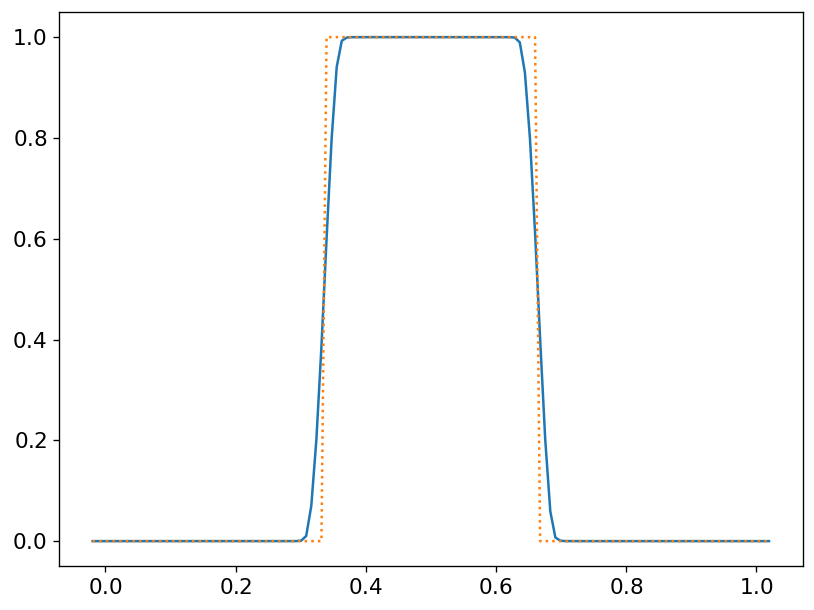

In [7]:
fig, ax = plt.subplots()
ax.plot(g.x, a)
ax.plot(g.x, tophat(g), ls=":")

We see that the profile looks quite good even after 10 periods.

## PPMpy `advection`

The `advection` module provides a function to do this evolution for us along with `sine` and `tophat` initial conditions.

In [8]:
from ppmpy.advection import advection, sine

In [9]:
nx = 64
C = 0.5
u = 1.0

In [12]:
g, a = advection(nx, u, C, init_cond=sine, num_periods=10)

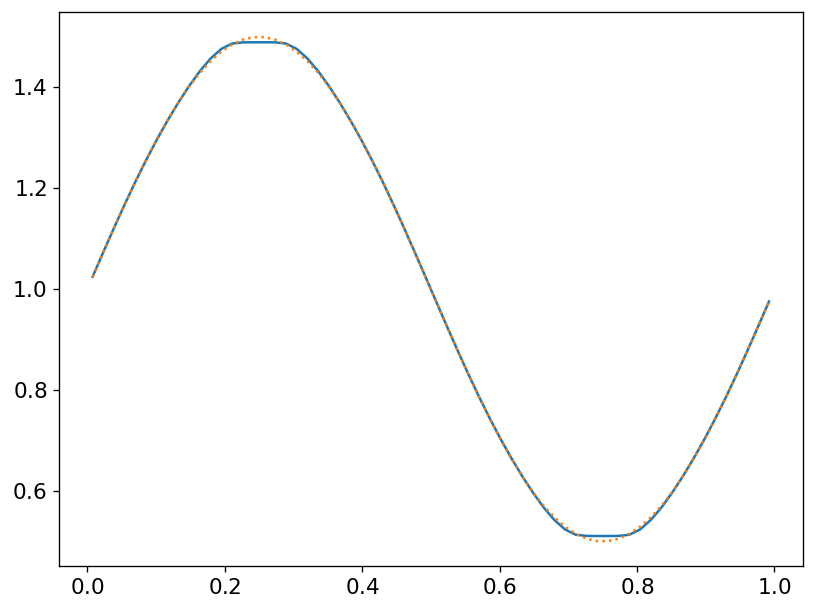

In [13]:
fig, ax = plt.subplots()
ax.plot(g.x[g.lo:g.hi+1], a[g.lo:g.hi+1])
ax.plot(g.x[g.lo:g.hi+1], sine(g)[g.lo:g.hi+1], ls=":")